In [1]:
# Importing all necessary libraries
import numpy as np
import pandas as pd
import cv2 as cv # requires manual install to Anaconda
import os
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
import gc
import requests
import random
from icrawler.builtin import GoogleImageCrawler # requires manual install to Anaconda
from sklearn.model_selection import train_test_split

# Keras, Tensorflow stuff for CNN/VGG
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam

# plot style preferences
style.use('fivethirtyeight')
sns.set_style("darkgrid")

%matplotlib inline

Using TensorFlow backend.


In [197]:
# Crawl for images of specified pokemon
pokemon = ['Pikachu', 'Squirtle', 'Bulbasaur', 'Charmander', 'Mewtwo']
for i in pokemon: 
    crawler = GoogleImageCrawler(storage={'root_dir': 'dataset/' + i})
    crawler.crawl(keyword=i, max_num=500, min_size=(96,96))

# ran this later to get detective pikachu images from google
# have to manual go through images to get outliers and then add the good ones
# to our main dataset manually
for i in pokemon: 
    crawler = GoogleImageCrawler(storage={'root_dir': 'outliers/' + i})
    crawler.crawl(keyword='Detective Pikachu ' + i, max_num=100, min_size=(96,96))

2020-06-25 00:54:16,335 - INFO - icrawler.crawler - start crawling...
2020-06-25 00:54:16,336 - INFO - icrawler.crawler - starting 1 feeder threads...
2020-06-25 00:54:16,337 - INFO - feeder - thread feeder-001 exit
2020-06-25 00:54:16,337 - INFO - icrawler.crawler - starting 1 parser threads...
2020-06-25 00:54:16,339 - INFO - icrawler.crawler - starting 1 downloader threads...
2020-06-25 00:54:16,919 - INFO - parser - parsing result page https://www.google.com/search?q=Detective+Pikachu+Squirtle&ijn=0&start=0&tbs=&tbm=isch
2020-06-25 00:54:17,095 - INFO - downloader - image #1	https://i.ytimg.com/vi/wbFt4PpwggQ/maxresdefault.jpg
2020-06-25 00:54:17,716 - INFO - downloader - image #2	https://cdn.vox-cdn.com/thumbor/7CFvl9b0UpEQviCDY0RfXzHBoZ0=/1400x0/filters:no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/16023556/Screen_Shot_2019_04_10_at_5.06.16_PM.png
2020-06-25 00:54:17,752 - INFO - downloader - image #3	https://i.ytimg.com/vi/DPE3J9ama_E/maxresdefault.jpg
2020-06-25 00:54:

2020-06-25 00:54:37,789 - INFO - downloader - image #46	https://en.freegames66.com/wp-content/uploads/posts/77eb10760b8342249f490b3ee8e62a64.jpg
2020-06-25 00:54:37,948 - INFO - downloader - image #47	https://www.channelnewsasia.com/image/11312896/1x1/600/600/5f39060743064ad8d1928bab67390c09/ge/snorlax-pokemon-detective-pikachu.png
2020-06-25 00:54:38,306 - INFO - downloader - image #48	https://static1.srcdn.com/wordpress/wp-content/uploads/2019/02/Detective-Pikachu-Pokemon-Header.jpg
2020-06-25 00:54:38,416 - INFO - downloader - image #49	https://img.ifunny.co/images/8f875b92c29da85d0db757abb6b9dfd793e72846880d56e3cb62bb61ea510ca0_1.jpg
2020-06-25 00:54:38,440 - INFO - downloader - image #50	https://pyxis.nymag.com/v1/imgs/635/968/cdd9e17681dc850b2dee6eb0f51d667313-06-detective-pikachu.rsquare.w700.jpg
2020-06-25 00:54:38,791 - INFO - downloader - downloaded images reach max num, thread downloader-001 is ready to exit
2020-06-25 00:54:38,792 - INFO - downloader - thread downloader-001

In [2]:
#constants
DATA_DIR = '/Users/brandonreid/Science/pokemon'
IMG_SIZE = 96
LEARN_RATE = 1e-4
IMAGE_DIMS = (IMG_SIZE, IMG_SIZE, 3)
EPOCHS = 100
SEED = 42
FIG_SIZE = (12, 5)
BS = 32

Total number of pokemon: 5
Total number of images: 1679


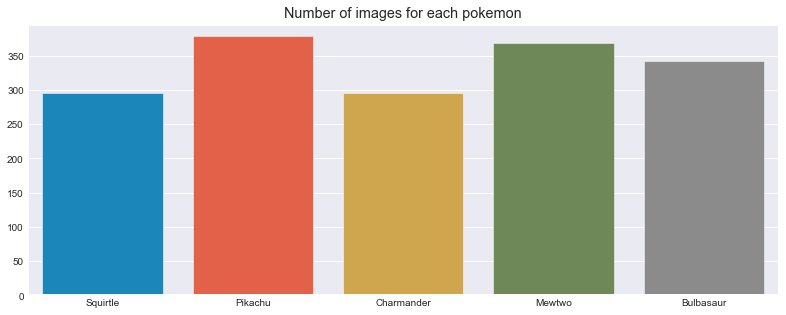

In [3]:
# obtain number of images for each pokemon
pokemon = os.listdir(DATA_DIR) 
print('Total number of pokemon:', len(pokemon))

images = {}
for poke in pokemon:
    images[poke] = len(os.listdir(os.path.join(DATA_DIR, poke)))
    
print('Total number of images:', sum(list(images.values())))

classes = list(images.keys())
counts = list(images.values())

fig = plt.figure(figsize = FIG_SIZE)
sns.barplot(x=classes, y=counts).set_title('Number of images for each pokemon')
plt.show()

In [4]:
data = [] # List for data (images)
labels = [] # List for data labels

# Loop through pokemon classes
for poke in pokemon:
    path = os.path.join(DATA_DIR, poke) # dir of pokemon
    
    # randomize image paths before resizing them
    image_paths = sorted(list(os.listdir(path)))
    random.seed(SEED)
    random.shuffle(image_paths)
    
    # loop over each image of pokemon
    for img in image_paths:
        image = cv.imread(os.path.join(path, img))
        try:
            data.append(cv.resize(image, (IMG_SIZE, IMG_SIZE))) # add resized image to dataset
            labels.append(pokemon.index(poke)) # add label as index of pokemon
        except: # error handling for unreadable images
            print(os.path.join(path, img), '-> UNREADABLE')
            continue

print(len(data), " TOTAL IMAGES PROCESSED")

/Users/brandonreid/Science/pokemon/Mewtwo/ed9eb0e7d3494c6992e06196f5b7cc05.svg -> UNREADABLE
/Users/brandonreid/Science/pokemon/Bulbasaur/000007.gif -> UNREADABLE
1677  TOTAL IMAGES PROCESSED


In [5]:
X = np.array(data).reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0 # Reshape and scale images
y = to_categorical(labels, num_classes = len(pokemon)) # Labelize

print("[INFO] data matrix: {:.2f}MB".format(
	X.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 362.23MB


In [6]:
# Cross Validation
# Popular method to train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = SEED)

In [7]:
# Defining ImageDataGenerator & construct data augmentation
# useful for fitting model to provide different image types, angles, rotations, etc.
# I have excluded this due to how much time it adds to trail the modal
# after looking further https://github.com/keras-team/keras/issues/12683
# this is a known issue
aug = ImageDataGenerator(rotation_range = 25, # Degree range for random rotations
                        width_shift_range = 0.1, # Range for horizontal shift
                        height_shift_range = 0.1, # Range for vertical shift 
                        zoom_range = 0.2, # Range for random zoom 
                        horizontal_flip = True, # Randomly flip inputs horizontally
                        shear_range = 0.2, # Shear Intensity
                        fill_mode="nearest")

aug.fit(X_train) # ideally would augment training image set

In [8]:
model = Sequential() # set up the modal for sequential layers

# SEQUENCE LAYER: CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same", input_shape=IMAGE_DIMS)) #CONV
model.add(Activation("relu")) #RELU
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(3, 3))) # POOL
model.add(Dropout(0.25)) #Dropout to next sequence

# SEQUENCE LAYER: (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Dropout to next sequence

# SEQUENCE LAYER: (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Dropout to next sequence

# SEQUENCE LAYER: first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5)) # Dropout to next sequence

# softmax classifier
model.add(Dense(len(pokemon))) # Dense is number of classes to predict
model.add(Activation("softmax"))

model.summary()

# optimizer
model.compile(Adam(lr=LEARN_RATE), loss='categorical_crossentropy', metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)       

In [9]:
history = model.fit(X_train, y_train, batch_size=BS, 
                 epochs=EPOCHS, verbose=1, validation_data=(X_test, y_test))

# history = model.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
#                     validation_data=(X_test, y_test),
#                     steps_per_epoch=len(X_train) // BS,
#                     epochs=EPOCHS, 
#                     verbose=1)

Train on 1341 samples, validate on 336 samples
Epoch 1/100
1341/1341 [==============================] - 50s 37ms/step - loss: 1.5503 - accuracy: 0.5019 - val_loss: 1.5788 - val_accuracy: 0.3869
Epoch 2/100
1341/1341 [==============================] - 45s 34ms/step - loss: 0.8934 - accuracy: 0.7278 - val_loss: 1.5542 - val_accuracy: 0.2351
Epoch 3/100
1341/1341 [==============================] - 46s 34ms/step - loss: 0.7302 - accuracy: 0.7673 - val_loss: 1.6577 - val_accuracy: 0.1875
Epoch 4/100
1341/1341 [==============================] - 45s 33ms/step - loss: 0.6033 - accuracy: 0.8061 - val_loss: 1.6550 - val_accuracy: 0.2411
Epoch 5/100
1341/1341 [==============================] - 45s 34ms/step - loss: 0.5659 - accuracy: 0.8166 - val_loss: 2.0370 - val_accuracy: 0.1875
Epoch 6/100
1341/1341 [==============================] - 45s 34ms/step - loss: 0.4423 - accuracy: 0.8553 - val_loss: 2.5136 - val_accuracy: 0.1994
Epoch 7/100
1341/1341 [==============================] - 45s 33ms/step 

1341/1341 [==============================] - 48s 36ms/step - loss: 0.0700 - accuracy: 0.9754 - val_loss: 0.6908 - val_accuracy: 0.8452
Epoch 57/100
1341/1341 [==============================] - 44s 33ms/step - loss: 0.0667 - accuracy: 0.9791 - val_loss: 0.5891 - val_accuracy: 0.8571
Epoch 58/100
1341/1341 [==============================] - 46s 35ms/step - loss: 0.0778 - accuracy: 0.9717 - val_loss: 0.6435 - val_accuracy: 0.8363
Epoch 59/100
1341/1341 [==============================] - 49s 36ms/step - loss: 0.0545 - accuracy: 0.9843 - val_loss: 0.5528 - val_accuracy: 0.8482
Epoch 60/100
1341/1341 [==============================] - 46s 34ms/step - loss: 0.0552 - accuracy: 0.9814 - val_loss: 0.6210 - val_accuracy: 0.8601
Epoch 61/100
1341/1341 [==============================] - 45s 34ms/step - loss: 0.0658 - accuracy: 0.9776 - val_loss: 0.6162 - val_accuracy: 0.8512
Epoch 62/100
1341/1341 [==============================] - 45s 34ms/step - loss: 0.0934 - accuracy: 0.9672 - val_loss: 0.5510 

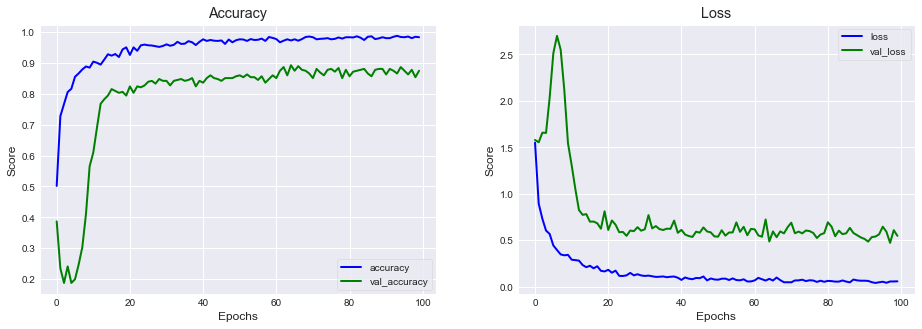

In [10]:
# Plot learning curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
 
acc_df = pd.Series(train_acc)
val_acc_df = pd.Series(val_acc)
loss_df = pd.Series(train_loss)
val_loss_df = pd.Series(val_loss)

fig = plt.figure(figsize = (14, 5))

plt.subplot(121)
sns.lineplot(data=acc_df, color='blue', label="accuracy", linewidth=2).set_title("Accuracy")
sns.lineplot(data=val_acc_df, color='green', label="val_accuracy", linewidth=2).set(xlabel='Epochs', ylabel='Score')
plt.legend(loc='lower right')

plt.subplot(122)
sns.lineplot(data=loss_df, color='blue', label="loss", linewidth=2).set_title("Loss")
sns.lineplot(data=val_loss_df, color='green', label="val_loss", linewidth=2).set(xlabel='Epochs', ylabel='Score')
plt.legend(loc='upper right')
plt.show()

In [11]:
# return image as array from web using requests
def get_image(url):
    r = requests.get(url, stream = True).raw
    return np.asarray(bytearray(r.read()), dtype="uint8")

In [66]:
# prediction and plot function for image
def predict_image(url, row, pos):
    # process image
    image = get_image(url)
    image = cv.imdecode(image, cv.IMREAD_COLOR)
    original_img = image
    image = cv.resize(image, (IMG_SIZE, IMG_SIZE)) # Resizing image to (96, 96)
    image = image.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0 # Reshape and scale resized image
    
    # run prediction
    preds = model.predict(image) # Predicting image
    pred_class = np.argmax(preds) # Defining predicted class

    # plot image with prediction outcome
    plots.add_subplot(row, 3, pos)
    plt.imshow(original_img[:, :, ::-1])
    plt.title(f'Predicted: {pokemon[pred_class]} {round(preds[0][pred_class] * 100, 2)}%')
    plt.axis('off')

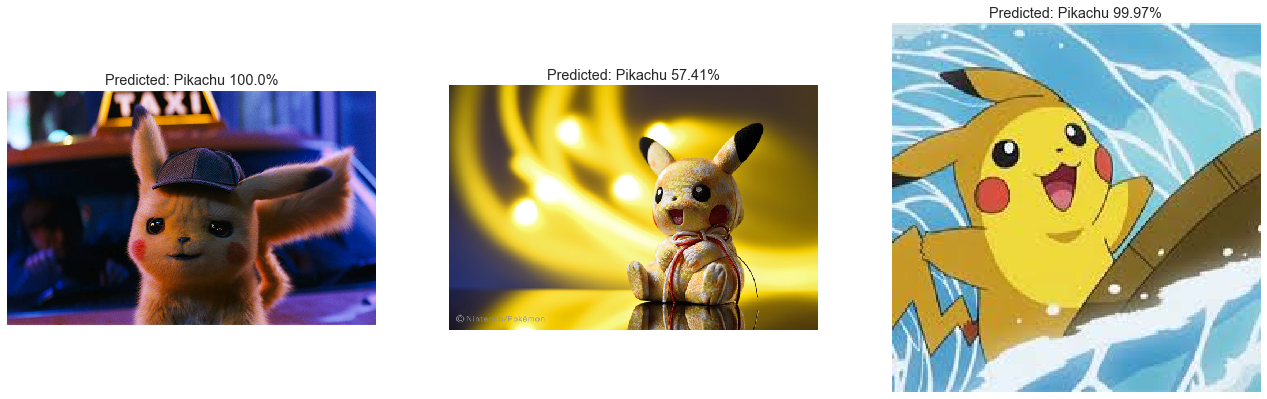

In [102]:
# predict pikachu images from web
pikachu3D = 'https://www.nme.com/wp-content/uploads/2019/05/MV5BZTNmOGE1ZmQtYjZmYy00MDhkLThkZjYtNzkyZDYxNTA5ZTE0XkEyXkFqcGdeQXVyNjg2NjQwMDQ@.jpg'
pikachuToy = 'https://soranews24.com/wp-content/uploads/sites/3/2019/11/pk-3.png?w=640&h=426'
pikachuOG = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQxX6o-s7rgiQGUrqeJJCws4uPLz9AxUqVMcA&usqp=CAU'

plots = plt.figure(figsize = (20, 20))

predict_image(pikachu3D, 1, 1)
predict_image(pikachuToy, 1, 2)
predict_image(pikachuOG, 1, 3)

plt.show()

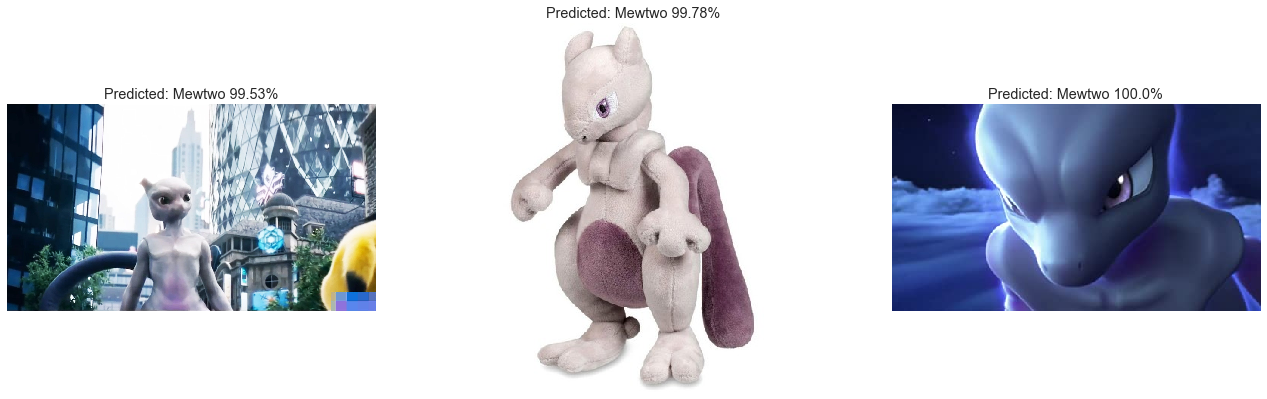

In [103]:
# predict mewtwo images from web
mewtwo3D = 'https://cdn.now.howstuffworks.com/media-content/3beb4197-0e43-4943-95b8-c432f6b0071a-1920-1080.jpg'
mewtwoToy = 'https://target.scene7.com/is/image/Target/GUEST_e5bb766e-140c-48ad-a323-1fde69087fed?wid=488&hei=488&fmt=pjpeg'
mewtwoOG = 'https://m.media-amazon.com/images/M/MV5BNjk1NTc3MDEtZDM4ZS00YzE2LThhNjEtMzdmZDcwMGJiNTA5XkEyXkFqcGdeQW1yb3NzZXI@._V1_UX477_CR0,0,477,268_AL_.jpg'

plots = plt.figure(figsize = (20, 20))

predict_image(mewtwo3D, 2, 1)
predict_image(mewtwoToy, 2, 2)
predict_image(mewtwoOG, 2, 3)

plt.show()

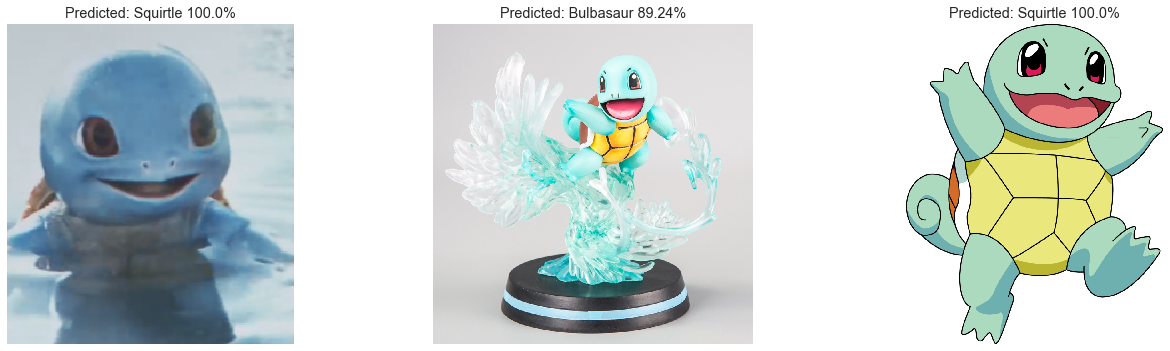

In [104]:
# predict squirtle images from web
squirtle3D = 'https://66.media.tumblr.com/6ac780a38a8d9eafed01daf41d6cd45b/tumblr_ps1sykZPEV1vplr8j_400.png'
squirtleToy = 'https://ae01.alicdn.com/kf/Hf096a66261864013886bd82540d9f4757/GK-Anime-Bulbasaur-Squirtle-Charmander-pikaqu-Charizard-Resin-Statue-Figure-Small-Fire-Dragon-PVC-Action-Figures.jpg'
squirtleOG = 'https://aguycalledkane.files.wordpress.com/2017/04/squirtle.png?w=840'

plots = plt.figure(figsize = (20, 20))

predict_image(squirtle3D, 3, 1)
predict_image(squirtleToy, 3, 2)
predict_image(squirtleOG, 3, 3)

plt.show()

# Failure with Toy image: Predicted was Bulbasaur, most likely do to edges in image

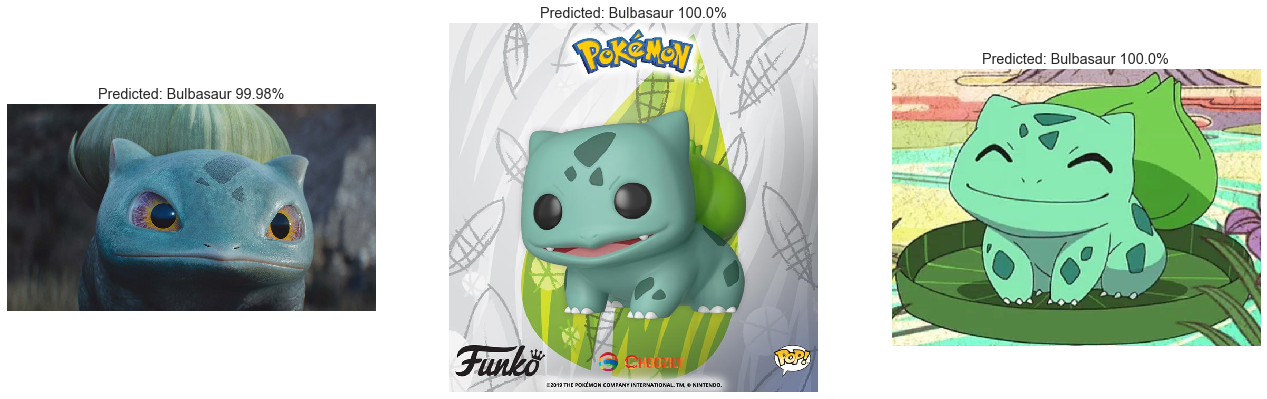

In [105]:
# predict bulbasuar images from web
bulbasuar3D = 'https://cdn1.thr.com/sites/default/files/2019/05/detective_pikachu-bulbasaur-publicity-h_2019.jpg'
bulbasuarOG = 'https://i.pinimg.com/736x/6f/aa/74/6faa74e32ce5f00f2dbc9c0b095cda52.jpg'
bulbasuarToy = 'https://www.choozily.com/wp-content/uploads/Funko-Pop-Bulbasaur-Pokemon-Vinyl-Figure-Choozily.jpg'

plots = plt.figure(figsize = (20, 20))

predict_image(bulbasuar3D, 1, 1)
predict_image(bulbasuarToy, 1, 2)
predict_image(bulbasuarOG, 1, 3)

plt.show()

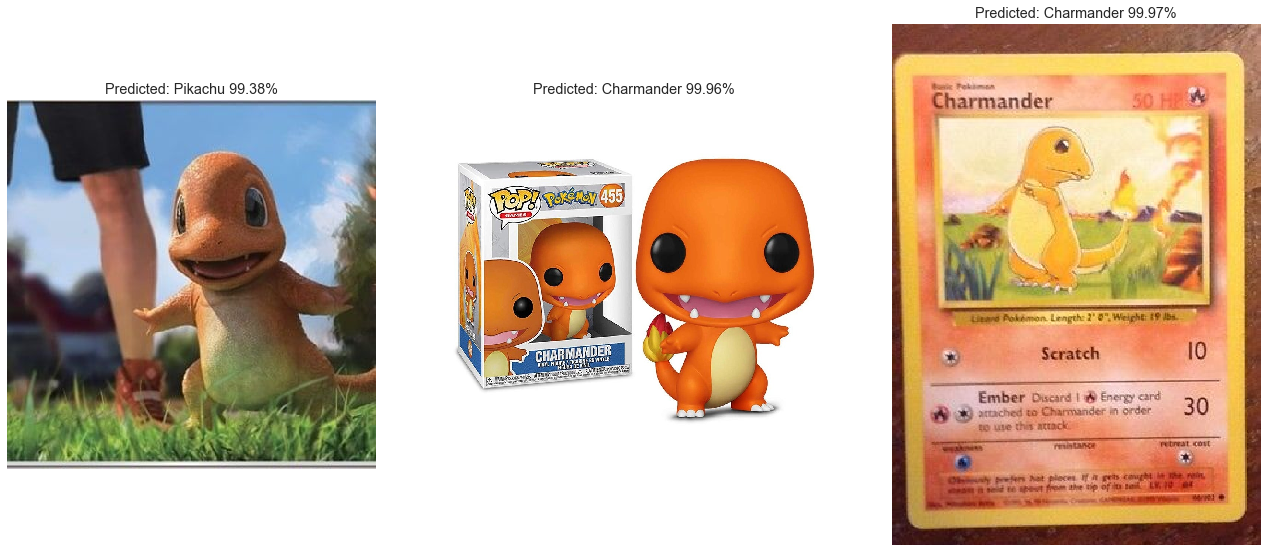

In [107]:
# predict charmander images from web
charmanderToy = 'https://ak1.ostkcdn.com/images/products/is/images/direct/2c9a494898df8ce9f85130f15683fdd2d80b9c51/Warp-Gadgets-Pok%C3%A9mon-Bundle-Funko-Pop-Charmander-and-Bulbasaur-2-Items.jpg'
charmander3D = 'https://i.pinimg.com/474x/48/8f/c4/488fc45206b15c68313706ca638d9441.jpg'
charmanderOG = 'https://i.ebayimg.com/images/g/-Z4AAOSwkShY8ocn/s-l400.jpg'

plots = plt.figure(figsize = (20, 20))

predict_image(charmander3D, 1, 1)
predict_image(charmanderToy, 1, 2)
predict_image(charmanderOG, 1, 3)

plt.show()

# Failure: 3D image from detective pikachu movie, Predicted Pikachu

In [ ]:
## References
# https://medium.com/@kelfun5354/building-a-simple-pokemon-convolutional-neural-net-cc724a8fb47d
# https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/
# https://www.youtube.com/watch?v=FmpDIaiMIeA
# https://www.geeksforgeeks.org/image-classifier-using-cnn/
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

## TODO
# Data/Image augmentation optimization
# crawl for more images on 3D versions
# Provide callback to fit model to monitor best fits